In [1]:
import os, glob
import pandas as pd
import numpy as np 
import torch
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)

In [2]:
os.getcwd()

'/opt/ml/code'

In [3]:
meta_data = pd.read_csv('../input/data/train/train.csv')

In [4]:
meta_data.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

<br></br>
<br></br>
### Meta Data 의 성별 분포

In [5]:
print(f"people count : {len(meta_data)}", end = '\n\n')
print(f"-- female & male ratio -- \n{meta_data.gender.value_counts() / len(meta_data)}", end = '\n\n')

people count : 2700

-- female & male ratio -- 
female    0.614074
male      0.385926
Name: gender, dtype: float64



<br></br>
<br></br>

### Meta data의 연령별 분포 정보

- 주로 20대, 60대가 많다. 정규성을 띄지 않음. 나이에 대한 편차가 존재 할까?

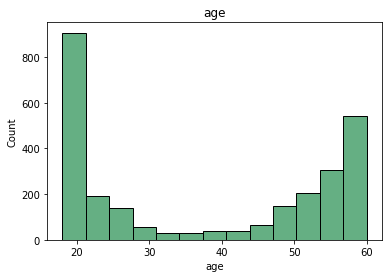

In [6]:
color = ['#ecf469','#d1e568','#b2dd53','#53c14f','#31945a']
sns.histplot(meta_data.age, color = color[4])
plt.title('age')
plt.show()

##### 특정 연령층 18-21, 50-60 때에 데이터가 집중되어 있다.

In [7]:
meta_data.groupby(['gender'])['age'].value_counts().unstack()

age        18     19     20    21    22    23    24    25    26   27    28  \
gender                                                                       
female  151.0  200.0  187.0  14.0  21.0  32.0  31.0  47.0  17.0  9.0  13.0   
male     41.0  207.0   80.0  27.0  37.0  40.0  31.0  35.0  27.0  6.0  12.0   

age       29    30   31   32   33    34    35   36   37   38   39    40   41  \
gender                                                                         
female  10.0   7.0  1.0  4.0  2.0  11.0  12.0  7.0  1.0  9.0  6.0  15.0  NaN   
male     6.0  10.0  2.0  3.0  3.0   2.0   7.0  1.0  2.0  5.0  NaN   5.0  7.0   

age       42    43    44    45   46   47    48    49    50    51    52    53  \
gender                                                                         
female  11.0  10.0  12.0  20.0  9.0  9.0  28.0  25.0  60.0  44.0  49.0  47.0   
male     2.0   8.0   1.0   7.0  5.0  1.0  11.0   6.0  20.0  19.0  29.0  17.0   

age       54    55    56    57     58    59     60  
gender                                              
female  58.0  67.0  76.0  69.0  109.0  39.0  109.0  
male    24.0  33.0  47.0  37.0   50.0  46.0   83.0

<br></br>
__세대별 (10살 간격으로) 데이터 분포__

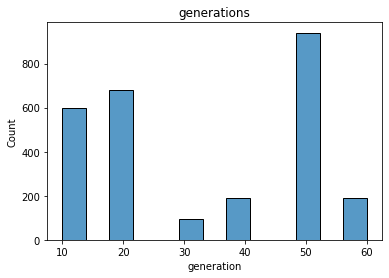

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


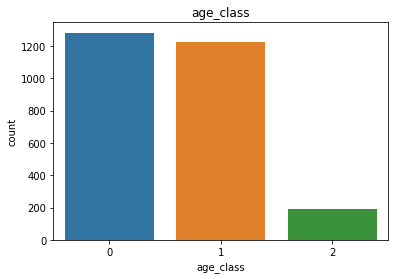

In [8]:
def get_age(data):
    return (data//10)*10
def get_age_class(data):
    if data < 30:
        return 0
    elif data < 60:
        return 1
    else:
        return 2 
meta_data['generation'] = meta_data.age.map(get_age)
meta_data['age_class'] = meta_data.age.map(get_age_class)
sns.histplot(meta_data.generation)
plt.title("generations")
plt.show()
sns.countplot(meta_data.age_class)
plt.title('age_class')
plt.show()

In [9]:
meta_data.groupby(['gender'])['generation'].value_counts().unstack().T

gender      female  male
generation              
10             351   248
20             381   301
30              60    35
40             139    53
50             618   322
60             109    83

In [10]:
meta_data.groupby(['gender'])['age_class'].value_counts().unstack().T

gender     female  male
age_class              
0             732   549
1             817   410
2             109    83

<br></br>

__세대별, 성별 데이터 분포__

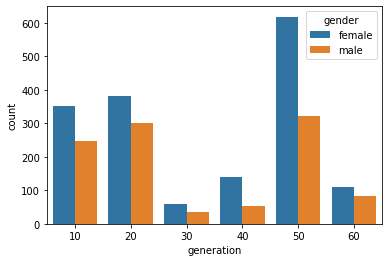

In [11]:
sns.countplot(x = meta_data.generation, hue=meta_data.gender)

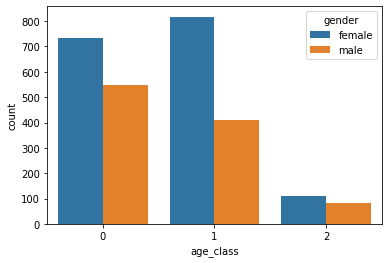

In [12]:
sns.countplot(x= meta_data.age_class, hue=meta_data.gender)

<br></br>
인원별로 데이터의 불균형이 존재하는가? 사람마다 데이터가 7가 되지 않는가?  
--> __그렇지는 않다.__

In [13]:
base_path = '/opt/ml/input/data/train/images'
# file load 함수 정의
def get_files(path):
    return glob.glob(os.path.join(base_path, path+'/*'))
total_data = 0
not_7 = {}
for i in range(len(meta_data)):
    file_length = len(get_files(meta_data.path.values[i]))
    total_data += file_length
    if file_length != 7:
        not_7.update({meta_data.id.values[i]:file_length})

In [14]:
print(total_data)
not_7

18900


{}

<br></br>
<br></br>
### Image data

- incorrect 데이터의 기준이 조금은 애매하다. mask 데이터의 기준은 `턱` 과 `코` 가완전히 가려져야 한다.

In [15]:
import re
from PIL import Image
# view 함수 정의
def plot_image(label, n):
    file_paths = [ file for path in meta_data.path.values for file in get_files(path) ]
    
    if label == 'incorrect':
        file_paths = [f for f in file_paths if 'incorrect' in f ]

    elif label == 'mask':
        mask = re.compile('mask[0-9+]')
        file_paths = [f for f in file_paths if mask.search(f)]

    elif label == 'normal':
        file_paths = [f for f in file_paths if 'normal' in f ]
    
    r_files = np.random.choice(file_paths, n)
    fig, axes = plt.subplots(nrows = n//5, ncols = 5, figsize = ( 20,20 ) ) 
    for i,ax in enumerate(axes.flatten()):
        image = np.asarray(Image.open(r_files[i]))
        ax.imshow(image)
        ax.set_title(str(image.shape) + '\n' + r_files[i].split("/")[-2] )
    plt.show()

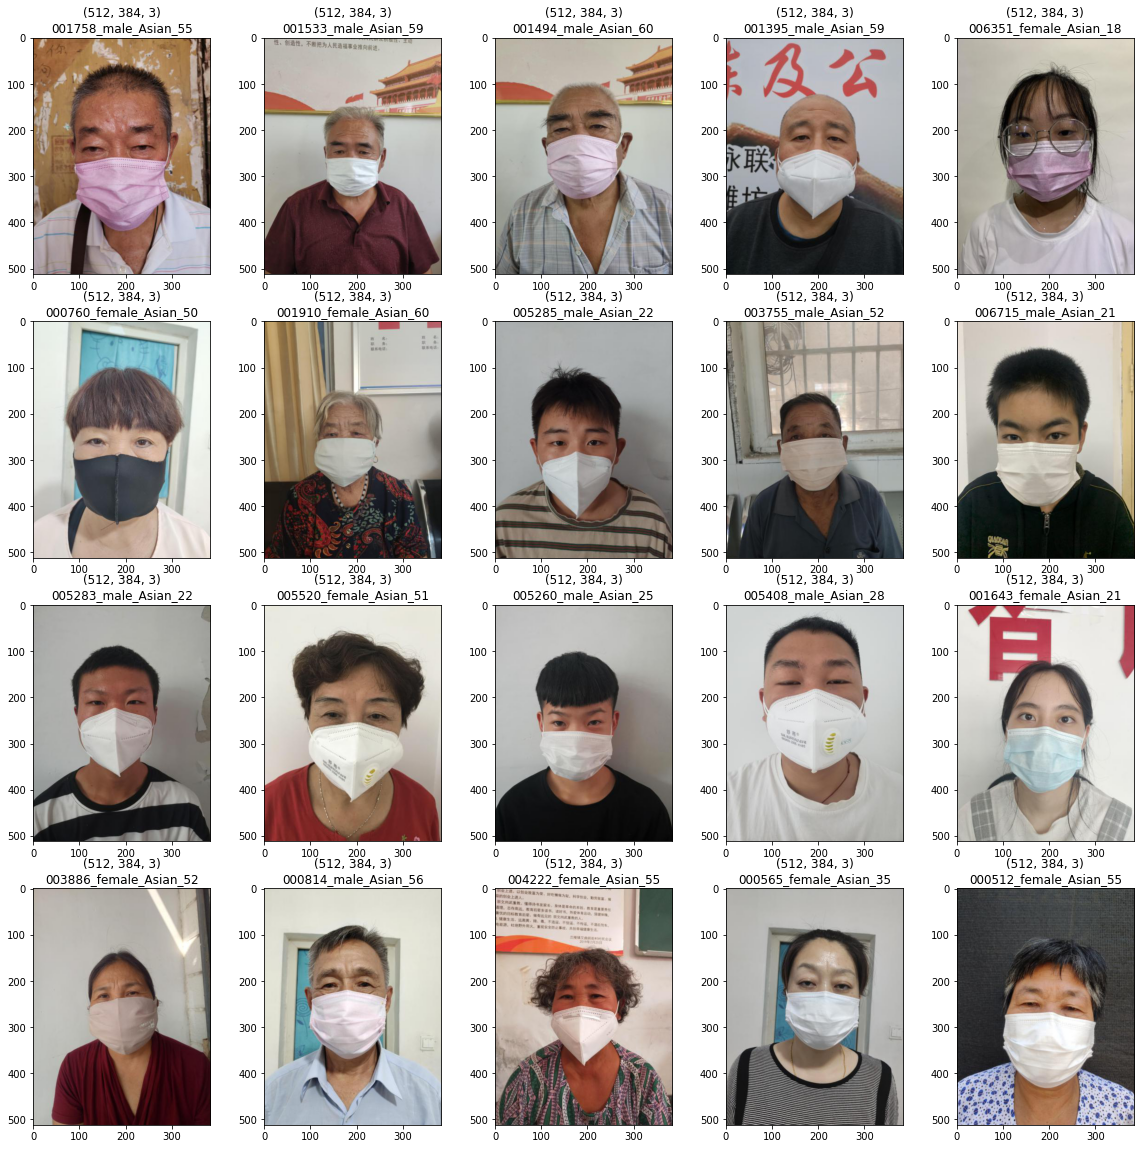

In [21]:
plot_image(label='mask', n = 20)

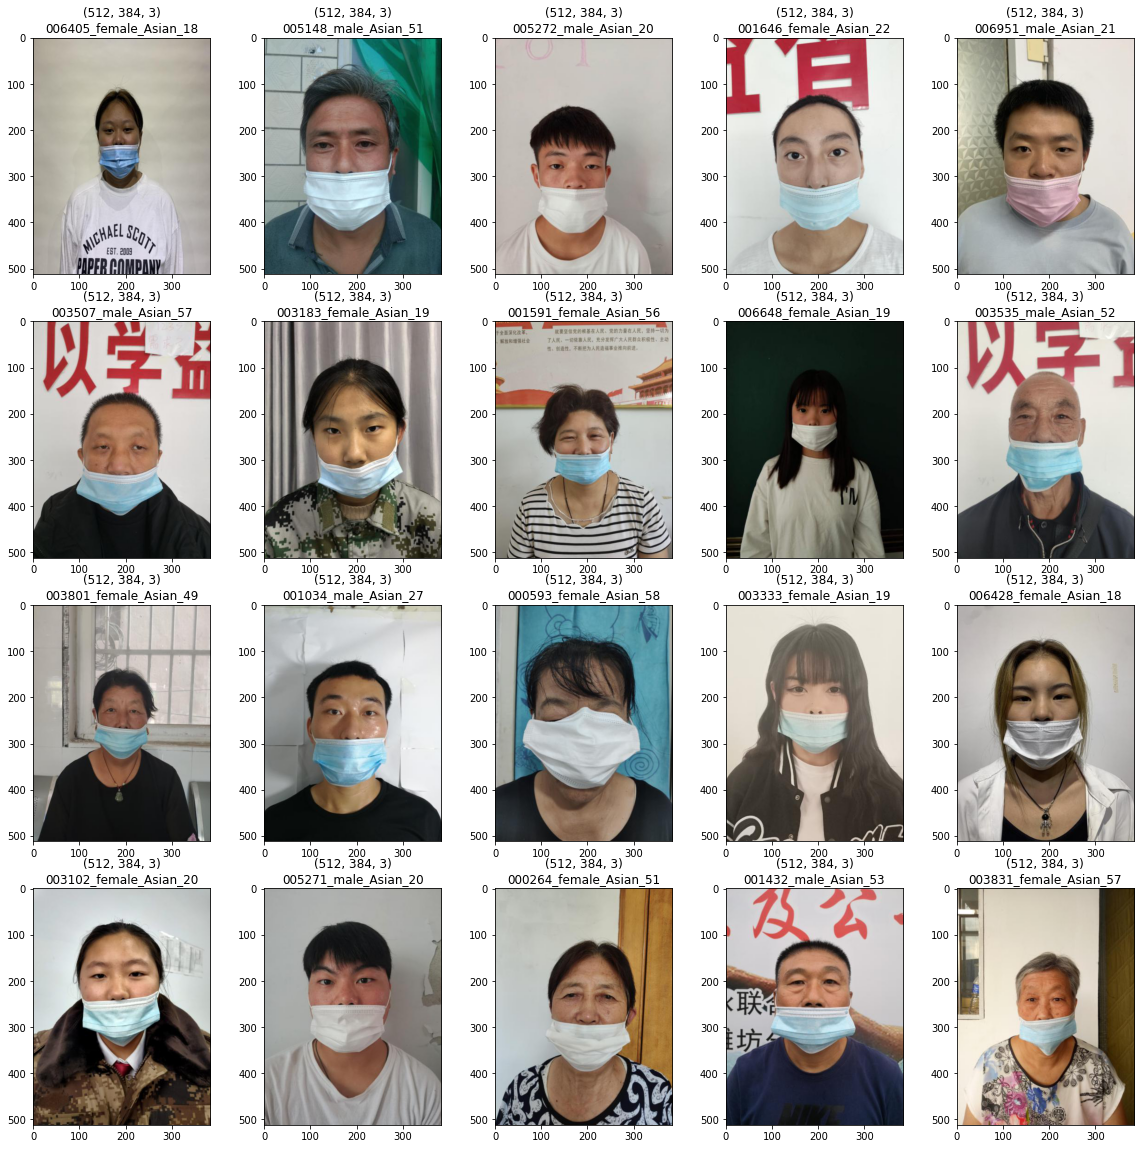

In [22]:
plot_image(label='incorrect', n = 20)

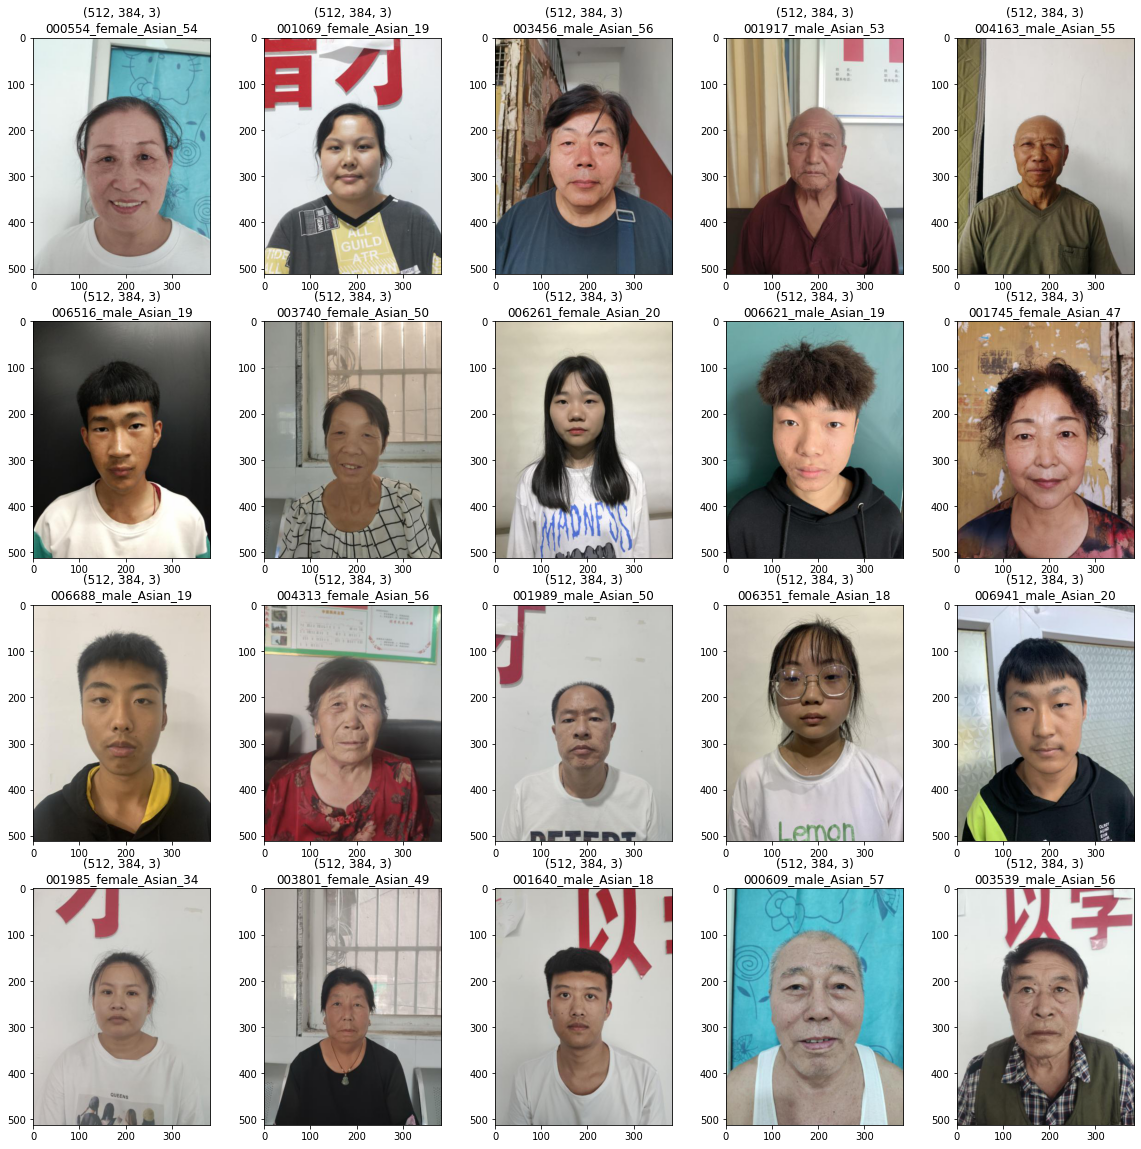

In [23]:
plot_image(label='normal', n = 20)

<br></br>
<br></br>

### Label 분포도

In [16]:
file_paths = [ file for path in meta_data.path.values for file in get_files(path) ]

In [17]:
def is_mask(img):
    if 'incorrect' in img:
        return 1
    elif 'mask' in img:
        return 0
    else:
        return 2

def get_age_class(data):
    data = int(data)
    if data < 30:
        return 0
    elif data < 60:
        return 1
    else:
        return 2 

def get_gender_logit(img):
    return 1 if 'female' in img else 0

def get_class(img):
    mask = is_mask(img)
    age = get_age_class( img.split('/')[-2].split('_')[-1] )
    gender = get_gender_logit(img)
    return mask*6 + gender*3 + age

label_list = [get_class(f) for f in file_paths]

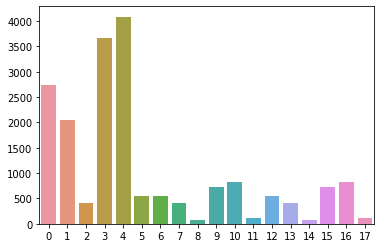

In [18]:
data = pd.Series(label_list).value_counts()
sns.barplot(x = data.index, y = data.values)

In [20]:
data.sort_index().values

array([2745, 2050,  415, 3660, 4085,  545,  549,  410,   83,  732,  817,
        109,  549,  410,   83,  732,  817,  109])

<br></br>


#### 최대한 데이터 간의 분포를 같게 할 순 없을까? 


- Oversampling을 통한 데이터 imbalancing 해결

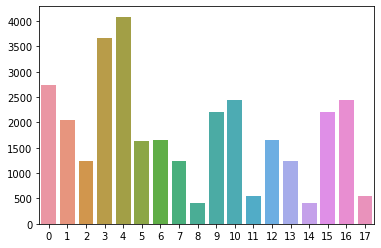

In [18]:
def get_files(path):
    # 특정 label의 size를 증가 할때 수정가능
    row_f_lst = glob.glob(os.path.join(base_path, path+'/*'))
    add_mask = [f for f in row_f_lst if ('incorrect' in f) or ('normal' in f)] * 2
    add_age = [f for f in row_f_lst if get_age_class( f.split('/')[-2].split('_')[-1] ) == 2] * 2
    return row_f_lst + add_mask + add_age
file_paths = [ file for path in meta_data.path.values for file in get_files(path) ]
label_list = [get_class(f) for f in file_paths]
data = pd.Series(label_list).value_counts()
sns.barplot(x = data.index, y = data.values)

In [19]:
data.sort_index().values

array([2745, 2050, 1245, 3660, 4085, 1635, 1647, 1230,  415, 2196, 2451,
        545, 1647, 1230,  415, 2196, 2451,  545])

<br></br>

- UnderSampling을 통한 해결

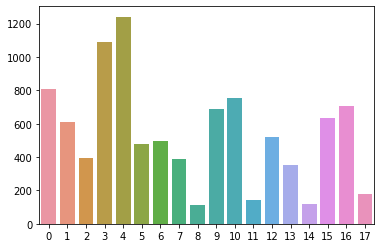

In [20]:
data = pd.Series(np.random.choice(label_list, int(len(label_list)*0.3))).value_counts()
sns.barplot(x = data.index, y = data.values)

In [19]:
import Datasets
import pandas as pd
meta_data = pd.read_csv('../input/data/train/train.csv')

In [20]:
meta_data.path.values

array(['000001_female_Asian_45', '000002_female_Asian_52',
       '000004_male_Asian_54', ..., '006956_male_Asian_19',
       '006957_male_Asian_20', '006959_male_Asian_19'], dtype=object)

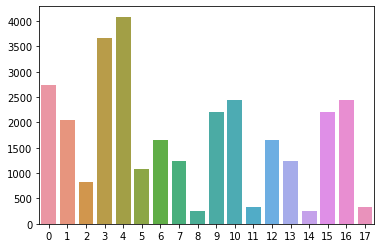

In [21]:
d = Datasets.OverSamplingMaskDataset(dir_paths=meta_data.path.values)
label_list = [get_class(f) for f in d.file_paths]
data = pd.Series(label_list).value_counts()
sns.barplot(x = data.index, y = data.values)

<br></br>
### Validation Dataset

- label의 분포에 따라 분류

In [36]:
meta_data.labels.value_counts()

4    817
3    732
0    549
1    410
5    109
2     83
Name: labels, dtype: int64

In [44]:
train, test = train_test_split(meta_data, train_size= 0.9, stratify=meta_data['labels'])
train.labels.value_counts()

4    735
3    659
0    494
1    369
5     98
2     75
Name: labels, dtype: int64

In [45]:
test.labels.value_counts()

4    82
3    73
0    55
1    41
5    11
2     8
Name: labels, dtype: int64

<br></br>
### Label 에 따른 데이터 증강

특정 나이의 데이터를 늘이던가, 아니면 집중되어 있는 데이터의 분포를 최소화 하는 방향으로 접근

In [1]:
import Datasets
import pandas as pd
import seaborn as sns

from collections import Counter
meta_data = pd.read_csv('../input/data/train/train.csv')

dataset = Datasets.OverSamplingMaskDataset(dir_paths=meta_data.path.values)
print(len(dataset.file_paths))
print(dataset.file_paths[0])
print(dataset.get_class(dataset.file_paths[0]))

20304
/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg
4


In [3]:
import os, glob
import Datasets
import numpy as np

def get_file(path):
    row_f_lst = glob.glob(os.path.join(dataset.base_path, path + '/*'))
    non_mask_data = [f for f in row_f_lst if not ('mask' in f.split('/')[-1].split('_')[0])]
    mask_data = [f for f in row_f_lst if 'mask' in f.split('/')[-1].split('_')[0]]

    if dataset.get_age_class(path.split('_')[-1]) != 2:
        if dataset.get_gender_logit(path) == 1:
            mask_data = np.random.choice(mask_data, 2, replace=False)
        else:
            mask_data = np.random.choice(mask_data, 3, replace=False)
        flst = list(mask_data) + list(non_mask_data)
    else:
        flst = mask_data*2 + non_mask_data*2
#     flst = mask_data + non_mask_data
    return flst


In [4]:
file_paths = [ f for fs in meta_data.path.values for f in get_file(fs)]
len(file_paths)

17046

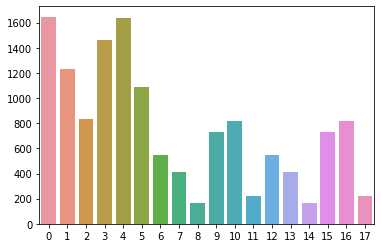

In [42]:
data = pd.Series([dataset.get_class(f) for f in file_paths]).value_counts()
sns.barplot(x=data.index, y=data.values)

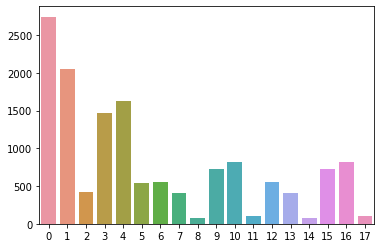

In [14]:
data = pd.Series([dataset.get_class(f) for f in dataset.file_paths]).value_counts()
sns.barplot(x=data.index, y=data.values)

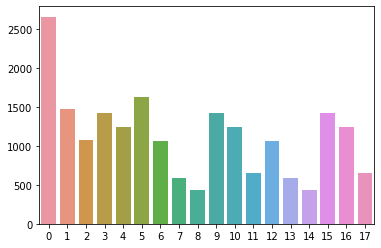

In [2]:
data = pd.Series([dataset.get_class(f) for f in dataset.file_paths]).value_counts()
sns.barplot(x=data.index, y=data.values)

In [5]:
data.sort_index().values

array([1593,  885, 2160, 1418, 1246, 3260,  531,  295,  432,  709,  623,
        652,  531,  295,  432,  709,  623,  652])

<br></br>
### Albumentaion 을 활용한 데이터 변형

In [1]:
import albumentations as A
import Datasets
import torchvision.transforms as transforms
import pandas as pd
import cv2

In [2]:
meta_data = pd.read_csv('../input/data/train/train.csv')

In [3]:
transform = Datasets.albumentation(size=(500,300), use_normalize=True)
dataset = Datasets.AlbumentationMaskDataset(dir_paths = meta_data.path.values, transform=transform)

In [1]:
import cv2
import matplotlib.pyplot as plt
import Datasets
img = cv2.imread("../input/data/train/images/000008_female_Asian_58/mask4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
t = Datasets.albumentation(size=(350,300), 
                           use_randcrop=False, use_center_crop=True, use_randomreisze_crop=False,
                           use_filp=True, use_rotate=True, use_blur=True,
                           use_noise=True, use_normalize=False, use_CLAHE=True,
                           use_invert=False, use_equalize=True, use_posterize=True,
                           use_soloarize=False, ues_jitter=False, use_Brightness=True,
                           use_Gamma=True, use_brightcontrast=False, use_cutout=False,
                           use_totensor=False
                                       )

In [64]:
import Datasets
import pandas as pd
import numpy as np

meta_data =pd.read_csv('../input/data/train/train.csv')

16


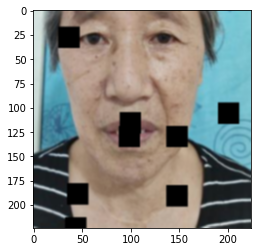

In [66]:
import matplotlib.pyplot as plt
print(dataset[1000][1])
plt.imshow(dataset[1000][0])